In [1]:
import pandas as pd

# Load the Excel file
excel_path = "Data_version_2.xlsx"  # Path to your file
df = pd.read_excel(excel_path, sheet_name="Final")

# Display basic info
print("✅ Data loaded successfully.")
print(df.head())

# Save to CSV for further use
csv_path = "soil_weather_data.csv"
df.to_csv(csv_path, index=False)

print(f"📁 Data saved to CSV as: {csv_path}")


✅ Data loaded successfully.
          State_Name  Rainfall_value  Tmax_value  Tmin_value  Soil Moisture  \
0  Andaman & Nicobar             NaN         NaN         NaN            NaN   
1  Andaman & Nicobar             NaN         NaN         NaN            NaN   
2  Andaman & Nicobar             NaN         NaN         NaN       0.165186   
3  Andaman & Nicobar             NaN         NaN         NaN       0.256472   
4  Andaman & Nicobar             NaN         NaN         NaN       0.319297   

  Time_Stamp  
0 2015-01-01  
1 2015-02-01  
2 2015-03-01  
3 2015-04-01  
4 2015-05-01  
📁 Data saved to CSV as: soil_weather_data.csv


In [2]:
# Load the CSV
df = pd.read_csv("soil_weather_data.csv")

# Check for missing values
print("🧼 Missing values per column:")
print(df.isnull().sum())


🧼 Missing values per column:
State_Name          0
Rainfall_value    240
Tmax_value        360
Tmin_value        360
Soil Moisture     111
Time_Stamp          0
dtype: int64


In [3]:
# Load the cleaned CSV (update filename if different)
df = pd.read_csv("soil_weather_data.csv")

# Ensure Time_Stamp is datetime
df['Time_Stamp'] = pd.to_datetime(df['Time_Stamp'], errors='coerce')

# Extract month number for grouping
df['Month'] = df['Time_Stamp'].dt.month


In [4]:
# Columns to fill
cols_to_fill = ['Rainfall_value', 'Tmax_value', 'Tmin_value', 'Soil Moisture']

# Fill each column with monthly mean per state
for col in cols_to_fill:
    df[col] = df.groupby(['State_Name', 'Month'])[col].transform(lambda x: x.fillna(x.mean()))


In [5]:
# Final catch-all for any remaining missing values
df[cols_to_fill] = df[cols_to_fill].fillna(method='ffill').fillna(method='bfill')


In [6]:
print("✅ Final check:")
print(df.isnull().sum())


✅ Final check:
State_Name        0
Rainfall_value    0
Tmax_value        0
Tmin_value        0
Soil Moisture     0
Time_Stamp        0
Month             0
dtype: int64


In [7]:
df = df.sort_values(by=['State_Name', 'Time_Stamp']).reset_index(drop=True)


In [8]:
# Convert Time_Stamp to datetime if not already
df['Time_Stamp'] = pd.to_datetime(df['Time_Stamp'])

# Define window size (days)
window_days = 7

df['Rainfall_last_7_days'] = (
    df.groupby('State_Name')['Rainfall_value']
    .transform(lambda x: x.rolling(window=window_days, min_periods=1).sum())
)



In [9]:
crop_thresholds = {
    'wheat': 25,    # percentage
    'rice': 35,
    'potato': 30,
    'tomato': 30
}


In [10]:
soil_moisture_threshold = crop_thresholds['wheat']
rainfall_threshold = 10  # mm over 7 days


In [11]:
df['Irrigation_Needed'] = (
    (df['Soil Moisture'] < soil_moisture_threshold) &
    (df['Rainfall_last_7_days'] < rainfall_threshold)
)


In [12]:
print(df[['State_Name', 'Time_Stamp', 'Soil Moisture', 'Rainfall_last_7_days', 'Irrigation_Needed']].sample(15))


                                    State_Name Time_Stamp  Soil Moisture  \
1868                                 Karnataka 2020-09-01       0.374561   
1774                                 Jharkhand 2022-11-01       0.200163   
3169                                Puducherry 2017-01-01       0.198811   
888   Daman and Diu and Dadra and Nagar Haveli 2019-01-01       0.137510   
2720                                 Meghalaya 2021-09-01       0.409594   
3607                                    Sikkim 2015-08-01       0.338371   
3779                                 Tamilnadu 2019-12-01       0.267510   
3801                                 Tamilnadu 2021-10-01       0.287756   
2190                               Lakshadweep 2017-07-01       0.320760   
4357                               West Bengal 2018-02-01       0.163502   
2422                               Maharashtra 2016-11-01       0.209657   
637                                 Chandigarh 2018-02-01       0.097820   
384         

In [13]:
import pandas as pd

# Assuming df is your cleaned dataframe
df['Time_Stamp'] = pd.to_datetime(df['Time_Stamp'])
df = df.sort_values(by=['State_Name', 'Time_Stamp'])

# Define irrigation thresholds per crop
crop_rules = {
    'Wheat':   {'sm': 35, 'rain': 10},
    'Rice':    {'sm': 45, 'rain': 15},
    'Potato':  {'sm': 40, 'rain': 10},
    'Tomato':  {'sm': 40, 'rain': 12},
}

all_crops_df = []

for crop_name, rule in crop_rules.items():
    crop_df = df.copy()
    crop_df['Crop'] = crop_name

    # Calculate rolling 7-day rainfall for each state
    crop_df['Rain_7days'] = crop_df.groupby('State_Name')['Rainfall_value'].rolling(window=7, min_periods=1).sum().reset_index(0, drop=True)

    # Apply rule-based labeling
    crop_df['Irrigation_Needed'] = crop_df.apply(
        lambda row: 1 if row['Soil Moisture'] < rule['sm'] and row['Rain_7days'] < rule['rain'] else 0,
        axis=1
    )

    all_crops_df.append(crop_df)

# Combine all crop-wise data into one dataset
labeled_df = pd.concat(all_crops_df, ignore_index=True)


In [14]:
# Overall class balance
print("🔍 Overall Class Distribution:")
print(labeled_df['Irrigation_Needed'].value_counts(), '\n')
print("✅ Percentages:")
print(labeled_df['Irrigation_Needed'].value_counts(normalize=True) * 100)

# Class distribution per crop
print("\n📊 Class Distribution Per Crop:")
crop_class_counts = labeled_df.groupby('Crop')['Irrigation_Needed'].value_counts().unstack()
crop_class_percent = labeled_df.groupby('Crop')['Irrigation_Needed'].value_counts(normalize=True).unstack() * 100

print("\nAbsolute counts:")
print(crop_class_counts)

print("\nPercentages:")
print(crop_class_percent)


🔍 Overall Class Distribution:
0    17604
1      156
Name: Irrigation_Needed, dtype: int64 

✅ Percentages:
0    99.121622
1     0.878378
Name: Irrigation_Needed, dtype: float64

📊 Class Distribution Per Crop:

Absolute counts:
Irrigation_Needed     0   1
Crop                       
Potato             4408  32
Rice               4388  52
Tomato             4400  40
Wheat              4408  32

Percentages:
Irrigation_Needed          0         1
Crop                                  
Potato             99.279279  0.720721
Rice               98.828829  1.171171
Tomato             99.099099  0.900901
Wheat              99.279279  0.720721


In [15]:
print(labeled_df.columns)


Index(['State_Name', 'Rainfall_value', 'Tmax_value', 'Tmin_value',
       'Soil Moisture', 'Time_Stamp', 'Month', 'Rainfall_last_7_days',
       'Irrigation_Needed', 'Crop', 'Rain_7days'],
      dtype='object')


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
# from imblearn.over_sampling import SMOTE

# Step 1: Encode categorical features
encoded_df = labeled_df.copy()

# Encode 'State_Name' and 'Crop'
le_state = LabelEncoder()
le_crop = LabelEncoder()
encoded_df['State_Code'] = le_state.fit_transform(encoded_df['State_Name'])
encoded_df['Crop_Code'] = le_crop.fit_transform(encoded_df['Crop'])

# Save encoders
joblib.dump(le_state, 'le_state.pkl')
joblib.dump(le_crop, 'le_crop.pkl')

# Step 2: Define features and target
features = ['Rainfall_value', 'Tmax_value', 'Tmin_value', 'Soil Moisture',
            'Rainfall_last_7_days', 'Month', 'State_Code', 'Crop_Code']
X = encoded_df[features]
y = encoded_df['Irrigation_Needed']
feature_cols = features  # This ensures consistency later


# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
feature_cols = X_train.columns.tolist()

# # Step 4: Apply SMOTE
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Optional: Check new class distribution
from collections import Counter
# print("Resampled class distribution:", Counter(y_train_resampled))


In [17]:
print("Training feature columns:", feature_cols)


Training feature columns: ['Rainfall_value', 'Tmax_value', 'Tmin_value', 'Soil Moisture', 'Rainfall_last_7_days', 'Month', 'State_Code', 'Crop_Code']


In [18]:
print("Test feature columns:", X_test.columns.tolist())


Test feature columns: ['Rainfall_value', 'Tmax_value', 'Tmin_value', 'Soil Moisture', 'Rainfall_last_7_days', 'Month', 'State_Code', 'Crop_Code']


c:\Users\zulka\anaconda3\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3521
           1       0.80      0.90      0.85        31

    accuracy                           1.00      3552
   macro avg       0.90      0.95      0.92      3552
weighted avg       1.00      1.00      1.00      3552



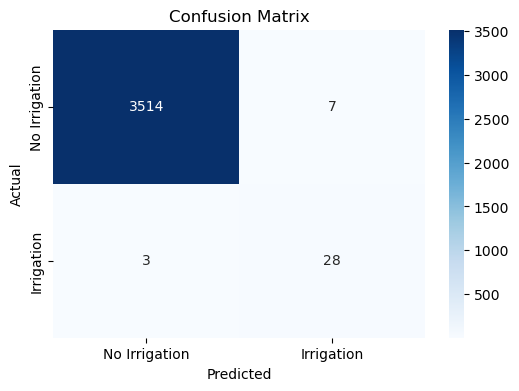

['rf_model.pkl']

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_train_resampled = pd.read_csv('X_train_resampled.csv')
y_train_resampled = pd.read_csv('y_train_resampled.csv')
# Step 1: Train the classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_resampled, y_train_resampled)

# X_test should already be a subset of encoded_df
X_test_fixed = X_test.copy()

# Add missing columns with default values
for col in feature_cols:
    if col not in X_test_fixed.columns:
        X_test_fixed[col] = 0

# Align column order exactly
X_test_fixed = X_test_fixed[feature_cols]

# ✅ Now prediction will work
y_pred = rf_model.predict(X_test_fixed)

# Make predictions
y_pred = rf_model.predict(X_test_fixed)

# Step 3: Evaluation
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# Step 4: Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Irrigation', 'Irrigation'],
            yticklabels=['No Irrigation', 'Irrigation'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

joblib.dump(rf_model, 'rf_model.pkl')


In [20]:
!pip install scikit-learn==1.6.1 --user



In [21]:
import sklearn
print(sklearn.__version__)

1.6.1


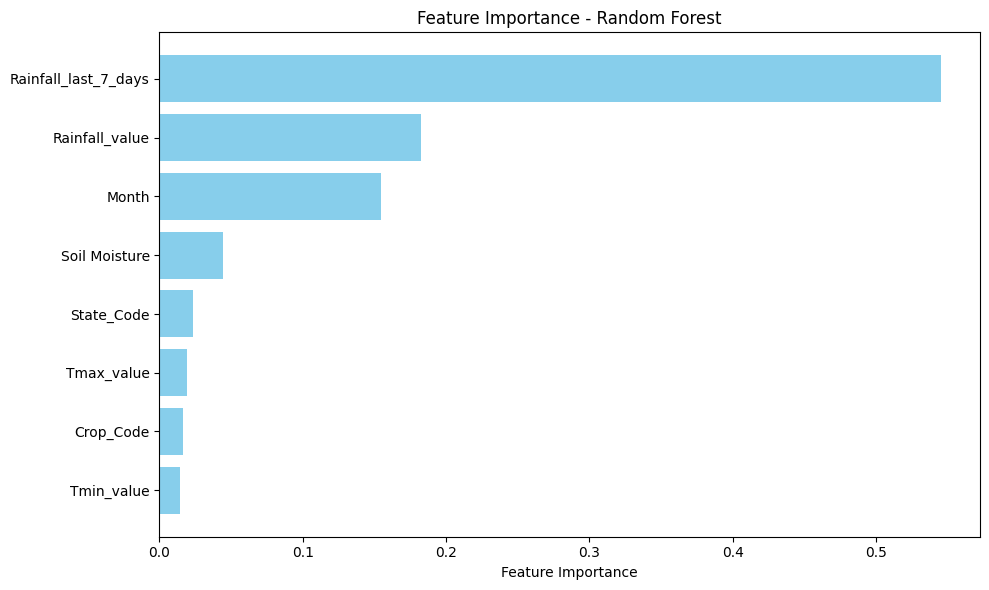

                Feature  Importance
4  Rainfall_last_7_days    0.545338
0        Rainfall_value    0.182204
5                 Month    0.154940
3         Soil Moisture    0.044109
6            State_Code    0.023493
1            Tmax_value    0.019006
7             Crop_Code    0.016306
2            Tmin_value    0.014605


In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Check your current feature set (used during model training)
features = X_train.columns
importances = rf_model.feature_importances_

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Also print for inspection
print(feat_imp_df)


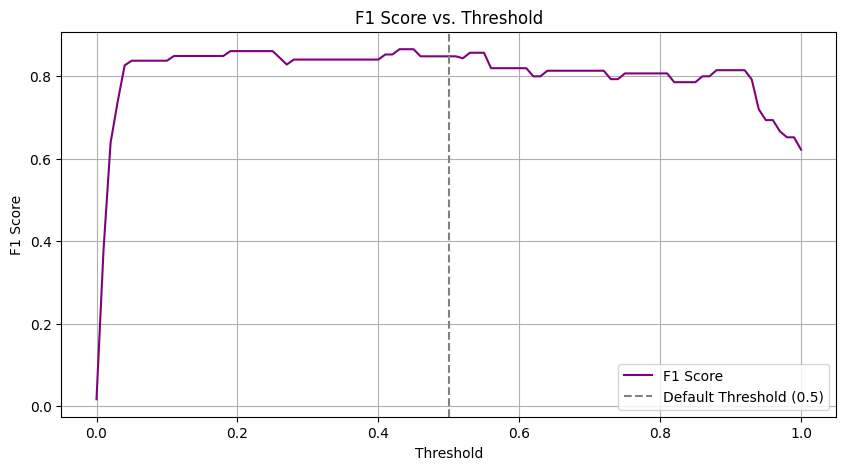

🔧 Best Threshold for F1 Score: 0.43


In [61]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
# Align test features with training features
X_test = encoded_df.loc[X_test.index, feature_cols]


# Get probabilities instead of labels
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Create precision-recall and f1 score for a range of thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple')
plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"🔧 Best Threshold for F1 Score: {best_threshold:.2f}")


📋 Classification Report (Threshold = 0.43):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3521
           1       0.81      0.94      0.87        31

    accuracy                           1.00      3552
   macro avg       0.90      0.97      0.93      3552
weighted avg       1.00      1.00      1.00      3552



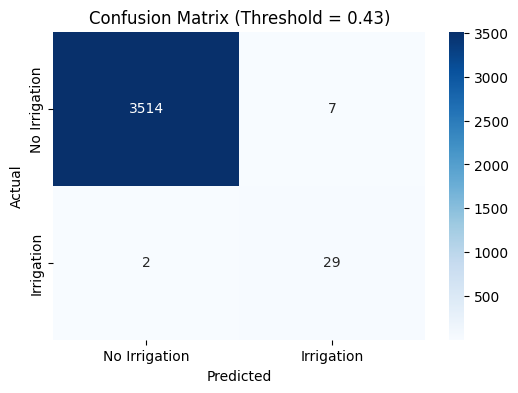

In [62]:
# Predict probabilities
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Apply custom threshold
best_threshold = 0.43
y_pred_custom = (y_proba >= best_threshold).astype(int)

# Re-evaluate performance
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("📋 Classification Report (Threshold = 0.43):")
print(classification_report(y_test, y_pred_custom))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Irrigation', 'Irrigation'],
            yticklabels=['No Irrigation', 'Irrigation'])
plt.title("Confusion Matrix (Threshold = 0.43)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [63]:
pip install shap


✅ sample_X shape: (100, 8)
✅ shap_values shape: (100, 8, 2)


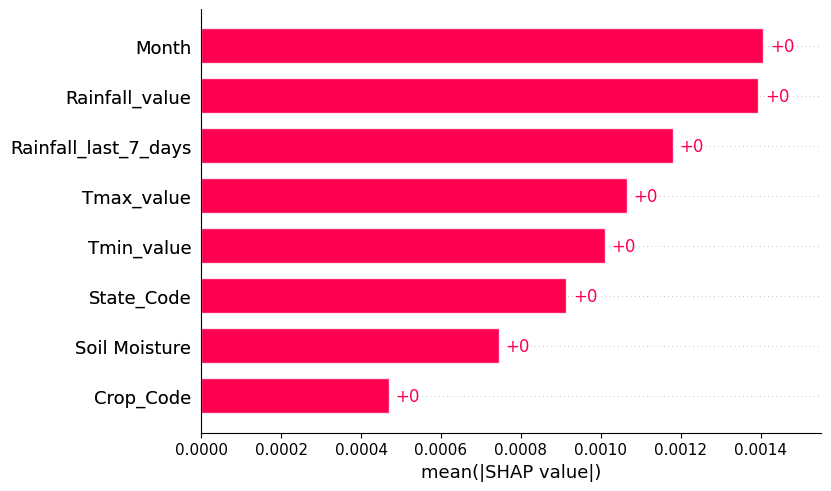

In [72]:
import shap

# Sample input for SHAP explanation
sample_X = X_test_fixed[X_train_resampled.columns].sample(100, random_state=42)

# Create SHAP explainer
explainer = shap.Explainer(rf_model, sample_X)

# Compute SHAP values for the sample
shap_values = explainer(sample_X)

# ✅ Confirm shapes
print("✅ sample_X shape:", sample_X.shape)
print("✅ shap_values shape:", shap_values.values.shape)

# Extract SHAP values for class 1 (Irrigation Needed)
# If it's binary classification, shap_values.values has shape (n_samples, n_features, 2)
values = shap_values.values[:, :, 1]  # class 1
base_values = shap_values.base_values[:, 1] if shap_values.base_values.ndim > 1 else shap_values.base_values
data = shap_values.data
feature_names = shap_values.feature_names

# Defensive check: Ensure feature name count matches number of features
if len(feature_names) != values.shape[1]:
    feature_names = [f'Feature {i}' for i in range(values.shape[1])]

# Wrap into a new Explanation object
shap_values_class1 = shap.Explanation(
    values=values,
    base_values=base_values,
    data=data,
    feature_names=feature_names
)

# Plot bar chart safely
shap.plots.bar(shap_values_class1)
